In [1]:
%load_ext rpy2.ipython

import pandas as pd
from metasub_utils.packet_parse import MetaSUBTableFactory
from capalyzer.packet_parser.experimental import umap
import warnings

warnings.filterwarnings('ignore')

core_tabler = MetaSUBTableFactory.all_factory()

/home/dcdanko/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
%%R

library(ggthemes)
library(ggplot2)
library(reshape2)
library(gridExtra)
library(ALDEx2)
library(RColorBrewer)

In [21]:
read_stats = core_tabler.csv_in_dir('other/read_stats.csv')
read_stats.columns = ['n_reads_post_qc', 'gc']
read_stats.head()

,n_reads_post_qc,gc
haib17CEM4890_H7KYMCCXY_SL273050,1587305.0,0.520939
haib17CEM4890_H75CGCCXY_SL263718,4663806.0,0.523686
haib18CEM5453_HMGW3CCXY_SL342346,3044550.0,0.461854
pilot_Sacramento-USA_Sample-1B,42947253.0,0.539972
haib17CEM4890_H2NYMCCXY_SL254845,17385304.0,0.481464


In [23]:
mdata = core_tabler.metadata
mdata.columns

def asfloat(val):
    try:
        return float(val)
    except ValueError:
        return float('nan')
    
def iscontrol(el):
    if el == 0:
        return 'Case'
    if el in ['ctrl cities']:
        return 'Bkgd Ctrl'
    if el in ['positive_control', 'poszymo']:
        return 'Pos Ctrl'
    if el in ['negative_control', 'dry tube', 'dry tube & swab', 'tube & rna/dna out', 'tube & rna/dna out & swab']:
        return 'Neg Ctrl'
    return 'Other'

qc_mdata = mdata[['num_reads', 'library_post_PCR_Qubit', 'library_QC_concentration',]]
qc_mdata = qc_mdata.dropna(how='all')
qc_mdata['library_post_PCR_Qubit'] = [asfloat(el) for el in qc_mdata['library_post_PCR_Qubit']]
qc_mdata['library_QC_concentration'] = [asfloat(el) for el in qc_mdata['library_QC_concentration']]
qc_mdata['control'] = core_tabler.metadata['control_type'].apply(iscontrol)
qc_mdata['flowcell'] = core_tabler.metadata['hudson_alpha_flowcell']
qc_mdata['flowcell'] = [str(el) for el in qc_mdata['flowcell']]

kmer_stats = core_tabler.csv_in_dir('other/kmer_complexity_stats.csv')
qc_mdata['kmer_entropy'] = kmer_stats.loc[qc_mdata.index, 'entropy']

read_stats = core_tabler.csv_in_dir('other/read_stats.csv')
read_stats.columns = ['n_reads_post_qc', 'gc']
qc_mdata['n_reads_post_qc'] = read_stats.loc[qc_mdata.index, 'n_reads_post_qc']
qc_mdata['gc'] = read_stats.loc[qc_mdata.index, 'gc']

print(qc_mdata.shape)
qc_mdata.head()

(3505, 8)


,num_reads,library_post_PCR_Qubit,library_QC_concentration,control,flowcell,kmer_entropy,n_reads_post_qc,gc
uuid,,,,,,,,
haib17CEM4890_H75CGCCXY_SL263637,3737675.0,369.8,2.5,Other,H75CGCCXY,19.935606,3734708.0,0.475989
haib17CEM4890_H75CGCCXY_SL263649,5191719.0,344.5,10.5,Other,H75CGCCXY,19.928191,5189022.0,0.528784
haib17CEM4890_H75CGCCXY_SL263661,5893643.0,480.6,12.5,Other,H75CGCCXY,19.886441,5891519.0,0.496385
haib17CEM4890_H75CGCCXY_SL263673,4561451.0,150.2,0.2,Other,H75CGCCXY,19.905967,4555459.0,0.608099
haib17CEM4890_H75CGCCXY_SL263685,5453802.0,311.8,15.4,Other,H75CGCCXY,19.952965,5450707.0,0.598064


In [24]:
mdata = core_tabler.metadata
mdata.columns

def asfloat(val):
    try:
        return float(val)
    except ValueError:
        return float('nan')

qc_mdata = mdata[['num_reads', 'library_post_PCR_Qubit', 'library_QC_concentration',]]
qc_mdata = qc_mdata.dropna(how='all')
qc_mdata['library_post_PCR_Qubit'] = [asfloat(el) for el in qc_mdata['library_post_PCR_Qubit']]
qc_mdata['library_QC_concentration'] = [asfloat(el) for el in qc_mdata['library_QC_concentration']]
qc_mdata['control'] = core_tabler.metadata['control_type_coarse']
qc_mdata['flowcell'] = core_tabler.metadata['hudson_alpha_flowcell']
qc_mdata['flowcell'] = [str(el) for el in qc_mdata['flowcell']]

kmer_stats = core_tabler.csv_in_dir('other/kmer_complexity_stats.csv')
qc_mdata['kmer_entropy'] = kmer_stats.loc[qc_mdata.index, 'entropy']

read_stats = core_tabler.csv_in_dir('other/read_stats.csv')
read_stats.columns = ['n_reads_post_qc', 'gc']
qc_mdata['n_reads_post_qc'] = read_stats.loc[qc_mdata.index, 'n_reads_post_qc']
qc_mdata['gc'] = read_stats.loc[qc_mdata.index, 'gc']
qc_mdata['control'] = qc_mdata['control'].fillna('case')


print(qc_mdata.shape)
qc_mdata.head()

(3505, 8)


,num_reads,library_post_PCR_Qubit,library_QC_concentration,control,flowcell,kmer_entropy,n_reads_post_qc,gc
uuid,,,,,,,,
haib17CEM4890_H75CGCCXY_SL263637,3737675.0,369.8,2.5,case,H75CGCCXY,19.935606,3734708.0,0.475989
haib17CEM4890_H75CGCCXY_SL263649,5191719.0,344.5,10.5,case,H75CGCCXY,19.928191,5189022.0,0.528784
haib17CEM4890_H75CGCCXY_SL263661,5893643.0,480.6,12.5,case,H75CGCCXY,19.886441,5891519.0,0.496385
haib17CEM4890_H75CGCCXY_SL263673,4561451.0,150.2,0.2,case,H75CGCCXY,19.905967,4555459.0,0.608099
haib17CEM4890_H75CGCCXY_SL263685,5453802.0,311.8,15.4,case,H75CGCCXY,19.952965,5450707.0,0.598064


In [25]:
qc_mdata['control'].unique()

array(['case'], dtype=object)

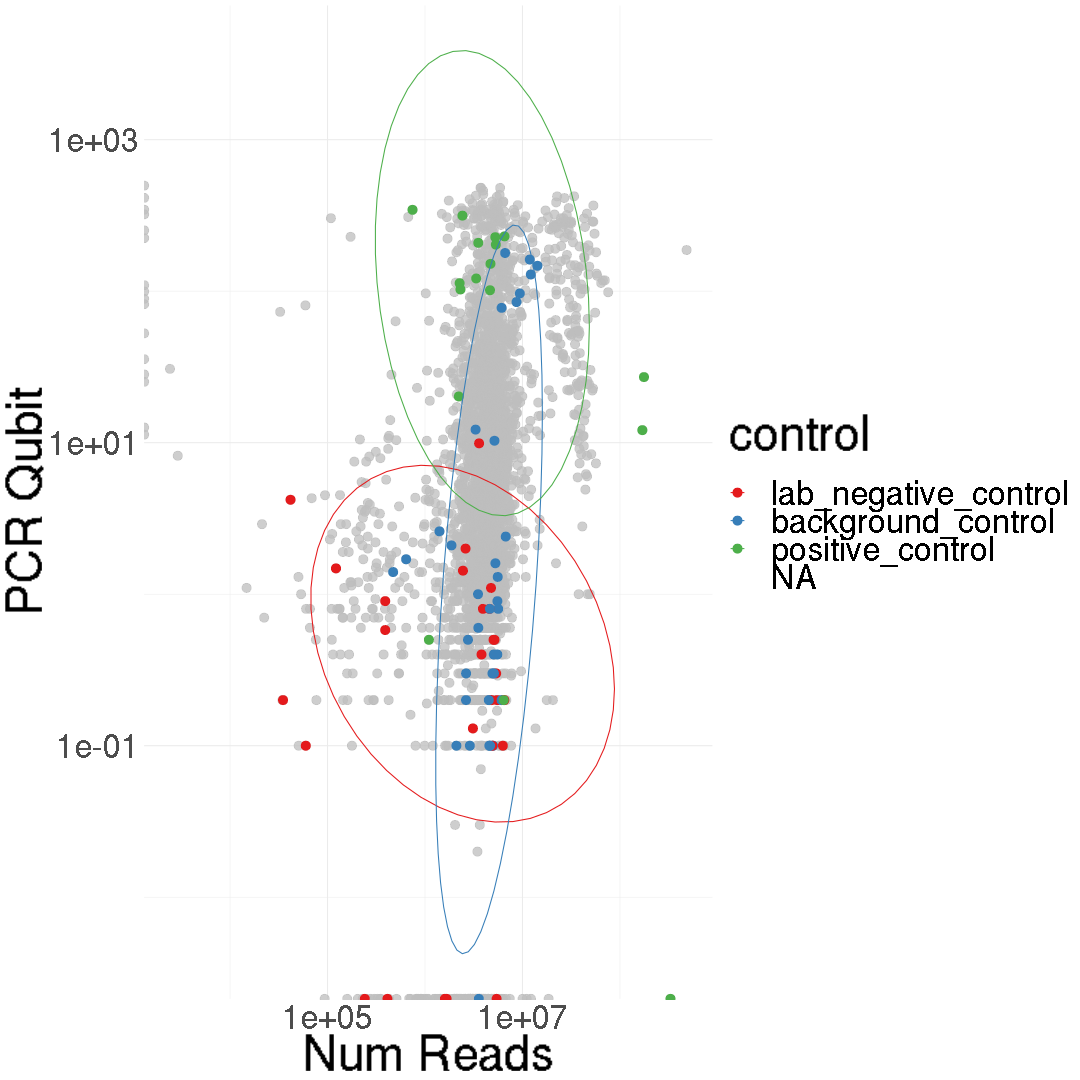

In [15]:
%%R -i qc_mdata -w 1080 -h 1080

qc_mdata$control = ordered(qc_mdata$control, levels=c('lab_negative_control', 'background_control', 'positive_control'))
ggplot(qc_mdata, aes(x=num_reads, y=library_post_PCR_Qubit, color=control)) +
    geom_point(size=4, alpha=0.75, color='grey') +
    geom_point(size=4, alpha=1, data=qc_mdata[qc_mdata$control != 'Case',]) +
    stat_ellipse(data=qc_mdata[qc_mdata$control != 'case',]) +
    theme_minimal() +
    ylab('PCR Qubit') +
    xlab('Num Reads') +
    scale_x_log10() +
    scale_y_log10() +
    scale_color_brewer(palette='Set1') +
    theme(
        text = element_text(size=50),
        legend.position='right',
    )

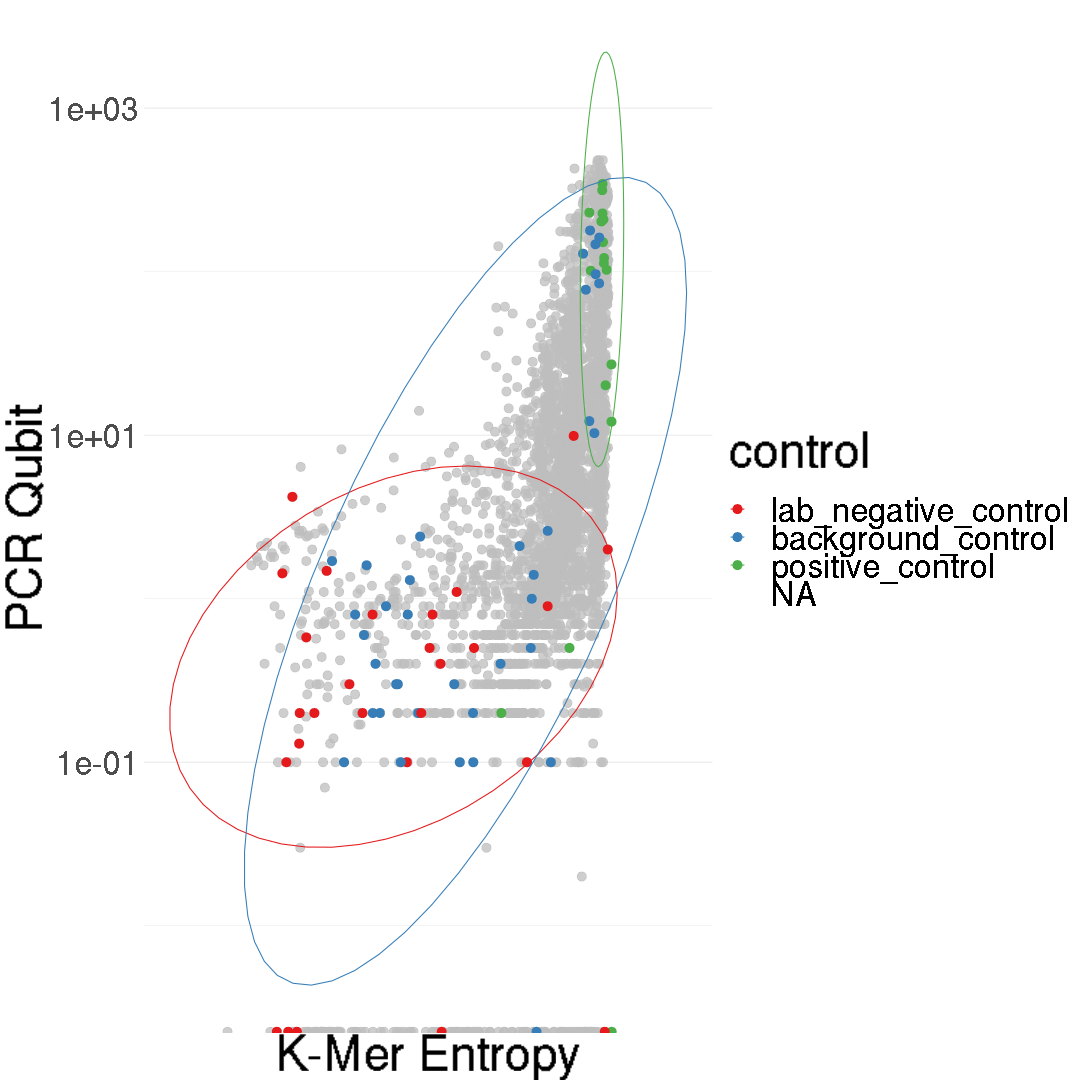

In [16]:
%%R -i qc_mdata -w 1080 -h 1080

qc_mdata$control = ordered(qc_mdata$control, levels=c('lab_negative_control', 'background_control', 'positive_control'))
ggplot(qc_mdata, aes(x=kmer_entropy, y=library_post_PCR_Qubit, color=control)) +
    geom_point(size=4, alpha=0.75, color='grey') +
    geom_point(size=4, alpha=1, data=qc_mdata[qc_mdata$control != 'case',]) +
    stat_ellipse(data=qc_mdata[qc_mdata$control != 'case',]) +
    theme_minimal() +
    ylab('PCR Qubit') +
    xlab('K-Mer Entropy') +
    scale_x_log10() +
    scale_y_log10() +
    scale_color_brewer(palette='Set1') +
    theme(
        text = element_text(size=50),
        legend.position='right',
    )

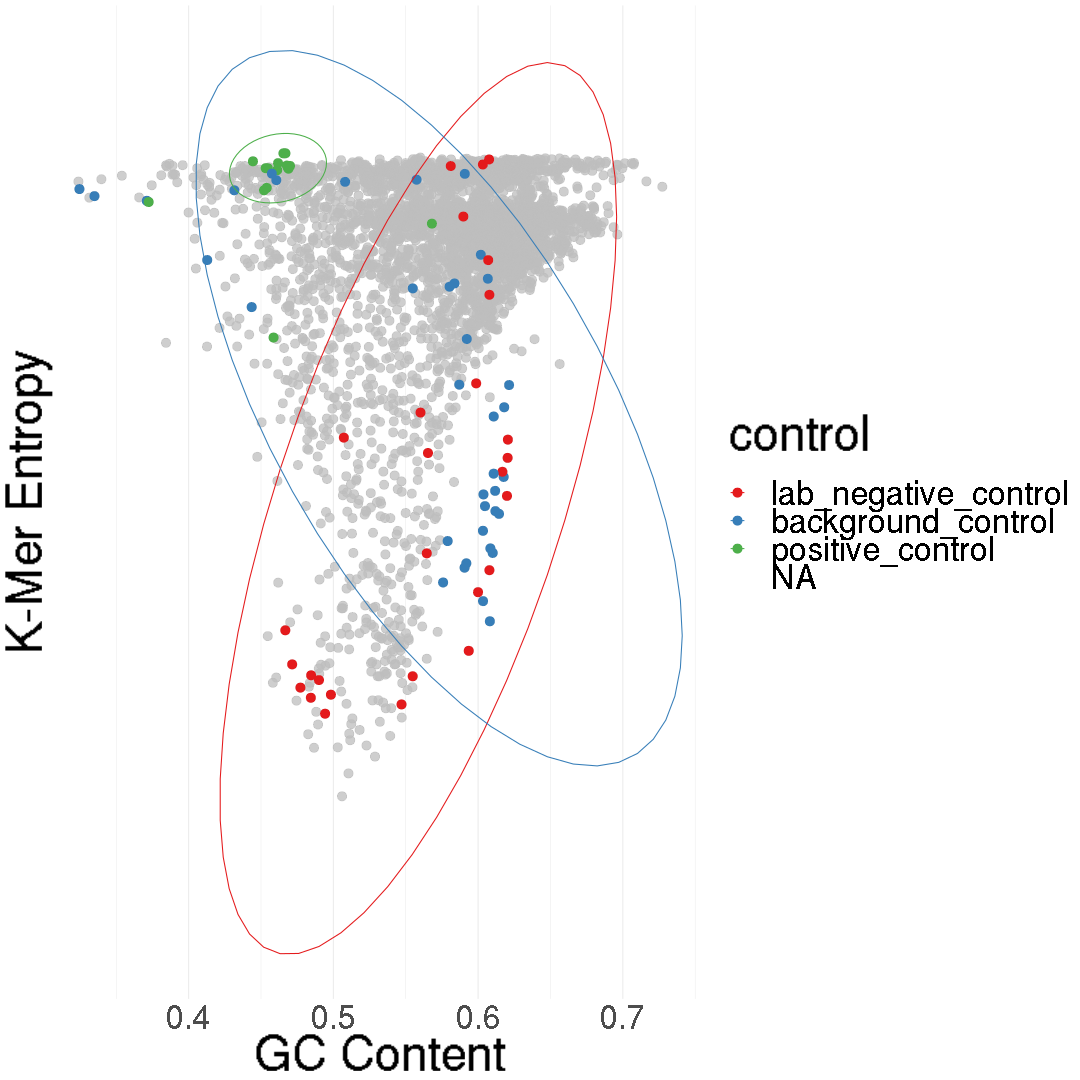

In [17]:
%%R -i qc_mdata -w 1080 -h 1080

qc_mdata$control = ordered(qc_mdata$control, levels=c('lab_negative_control', 'background_control', 'positive_control'))
ggplot(qc_mdata, aes(x=gc, y=kmer_entropy, color=control)) +
    geom_point(size=4, alpha=0.75, color='grey') +
    geom_point(size=4, alpha=1, data=qc_mdata[qc_mdata$control != 'case',]) +
    stat_ellipse(data=qc_mdata[qc_mdata$control != 'case',]) +
    theme_minimal() +
    ylab('K-Mer Entropy') +
    xlab('GC Content') +
    scale_y_log10() +
    scale_color_brewer(palette='Set1') +
    theme(
        text = element_text(size=50),
        legend.position='right',
    )

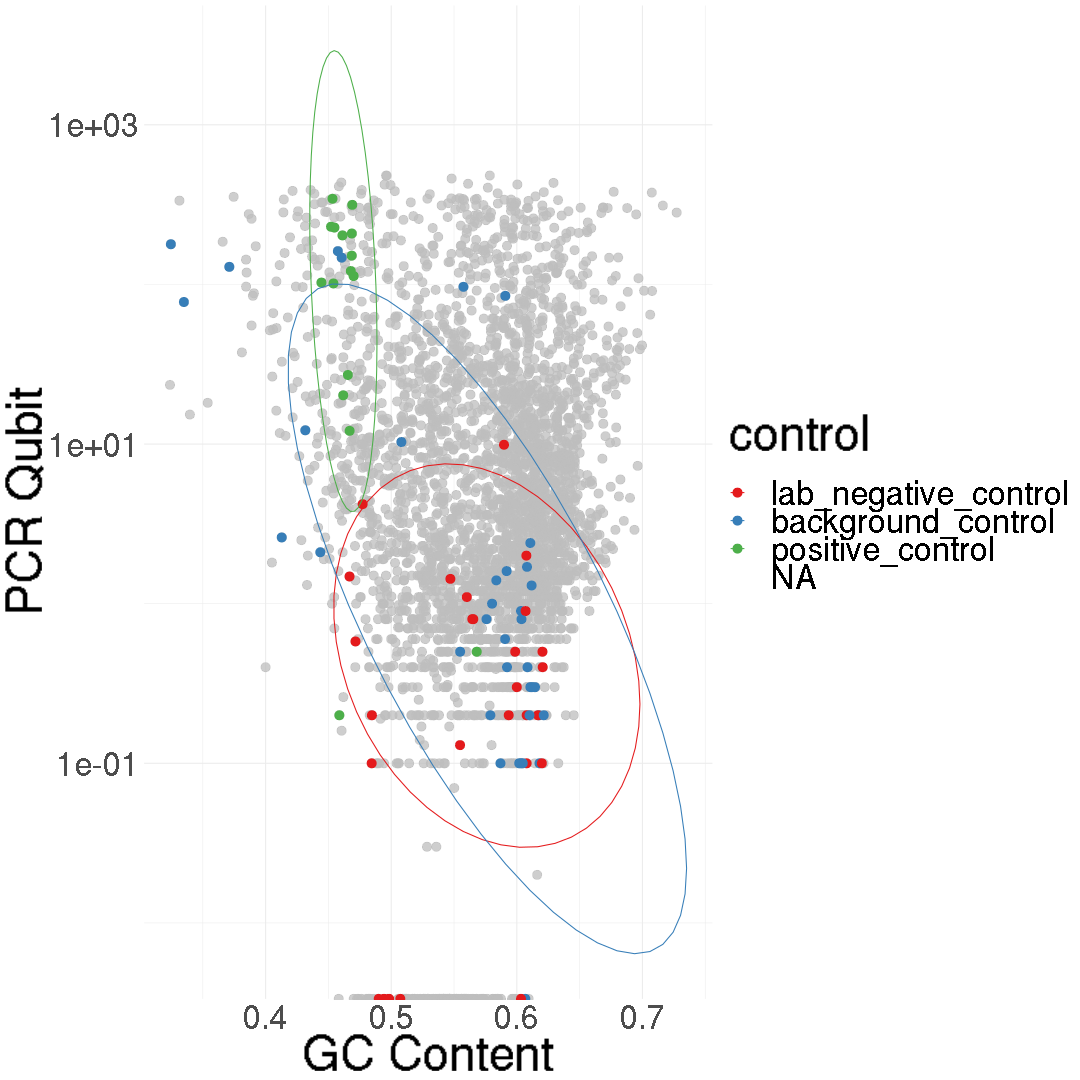

In [19]:
%%R -i qc_mdata -w 1080 -h 1080

qc_mdata$control = ordered(qc_mdata$control, levels=c('lab_negative_control', 'background_control', 'positive_control'))
ggplot(qc_mdata, aes(x=gc, y=library_post_PCR_Qubit, color=control)) +
    geom_point(size=4, alpha=0.75, color='grey') +
    geom_point(size=4, alpha=1, data=qc_mdata[qc_mdata$control != 'case',]) +
    stat_ellipse(data=qc_mdata[qc_mdata$control != 'case',]) +
    theme_minimal() +
    ylab('PCR Qubit') +
    xlab('GC Content') +
    scale_y_log10() +
    scale_color_brewer(palette='Set1') +
    theme(
        text = element_text(size=50),
        legend.position='right',
    )

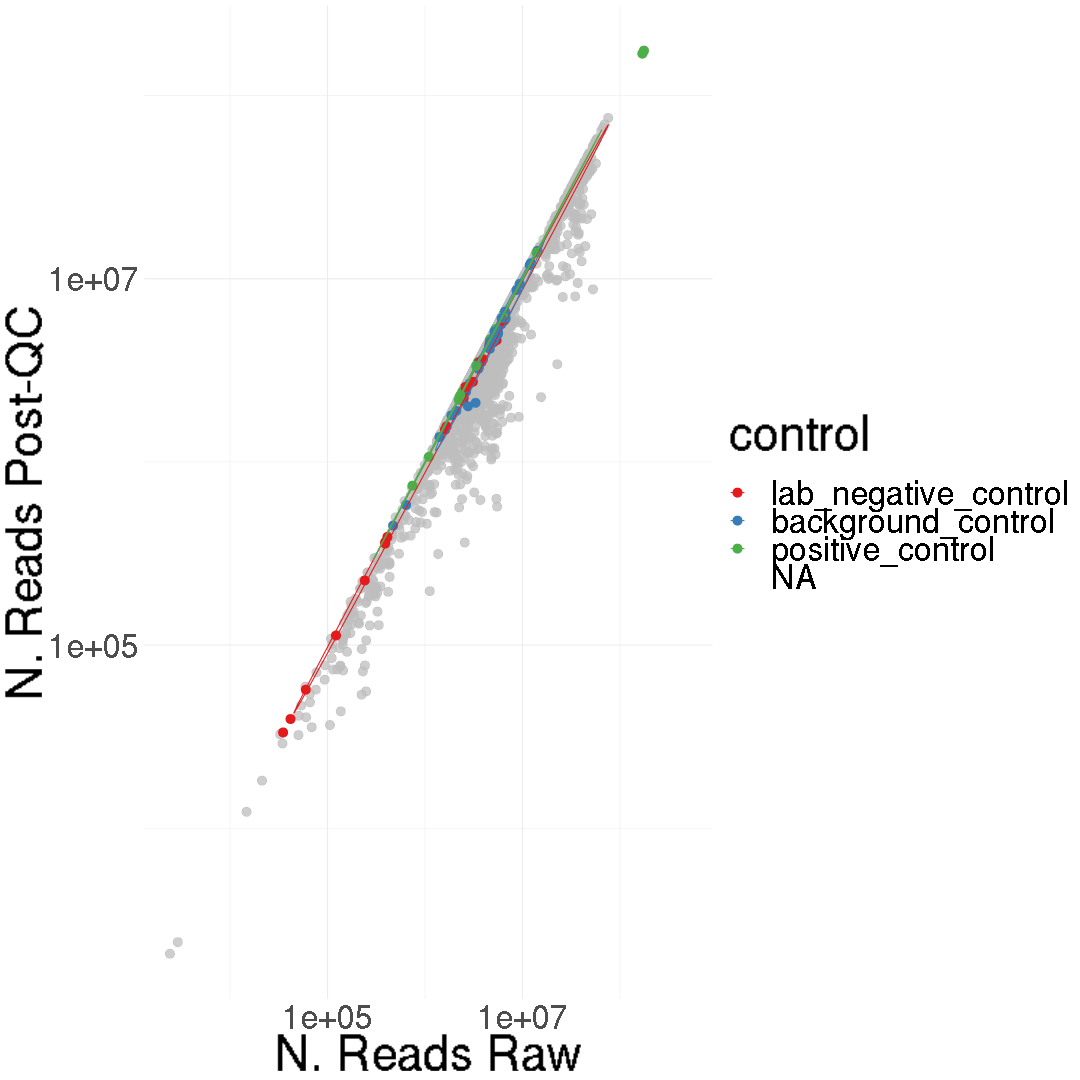

In [18]:
%%R -i qc_mdata -w 1080 -h 1080

qc_mdata$control = ordered(qc_mdata$control, levels=c('lab_negative_control', 'background_control', 'positive_control'))
ggplot(qc_mdata, aes(x=num_reads, y=n_reads_post_qc, color=control)) +
    geom_point(size=4, alpha=0.75, color='grey') +
    geom_point(size=4, alpha=1, data=qc_mdata[qc_mdata$control != 'case',]) +
    stat_ellipse(data=qc_mdata[qc_mdata$control != 'case',]) +
    theme_minimal() +
    ylab('N. Reads Post-QC') +
    xlab('N. Reads Raw') +
    scale_y_log10() +
    scale_x_log10() +
    scale_color_brewer(palette='Set1') +
    theme(
        text = element_text(size=50),
        legend.position='right',
    )

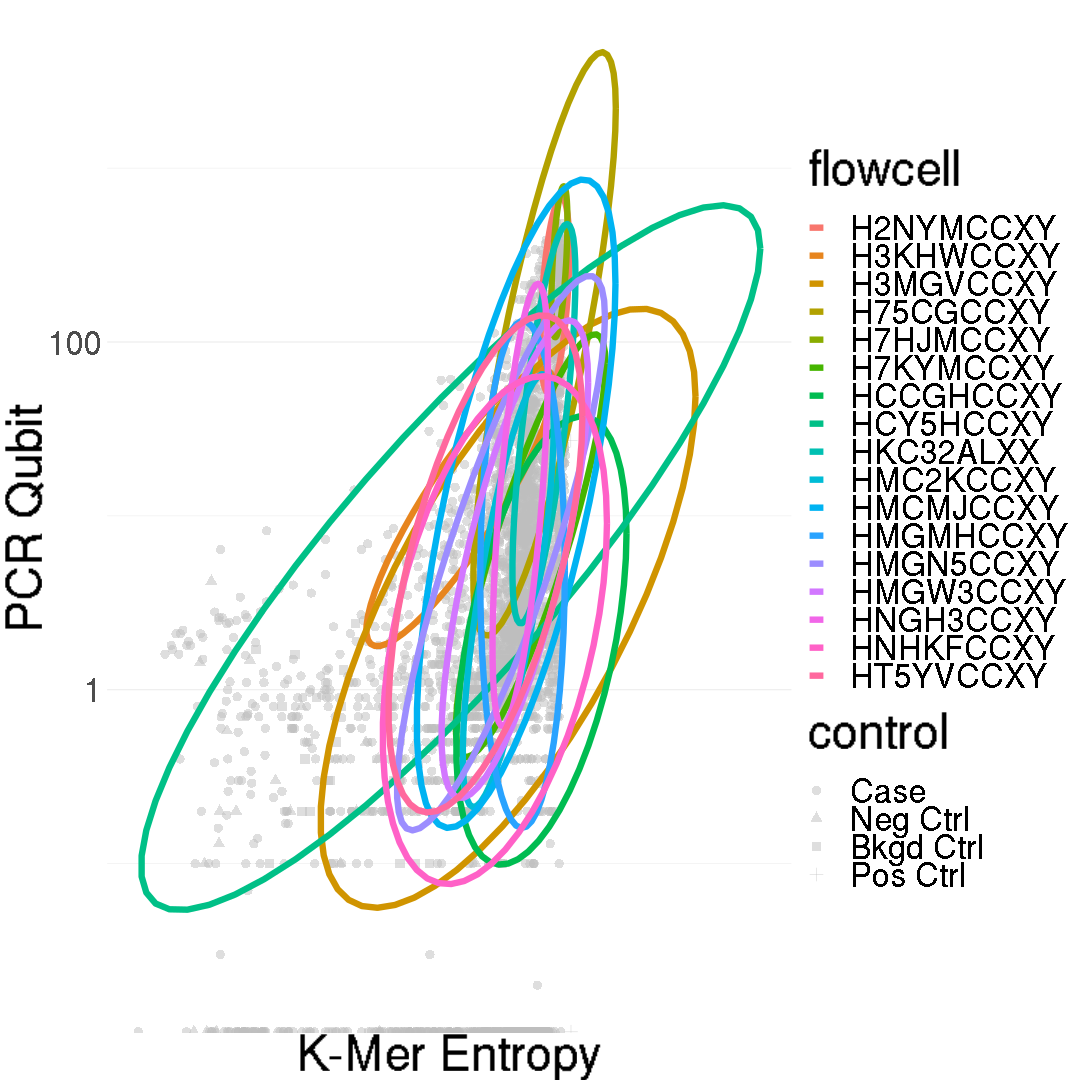

In [26]:
%%R -i qc_mdata -w 1080 -h 1080


fcs = c('HCY5HCCXY', 'HNHKFCCXY', 'HT5YVCCXY', 'HCCGHCCXY', 'HMCMJCCXY')
qc_mdata$control = ordered(qc_mdata$control, levels=c('Case', 'Neg Ctrl', 'Bkgd Ctrl', 'Pos Ctrl'))
ggplot(qc_mdata, aes(x=kmer_entropy, y=library_post_PCR_Qubit, color=flowcell, shape=control)) +
    geom_point(size=4, alpha=0.5, color='grey') +
    stat_ellipse(aes(x=kmer_entropy, y=library_post_PCR_Qubit, color=flowcell), inherit.aes=F, size=3) +
    theme_minimal() +
    ylab('PCR Qubit') +
    xlab('K-Mer Entropy') +
    scale_x_log10() +
    scale_y_log10() +
    theme(
        text = element_text(size=50),
        legend.position='right',
    )

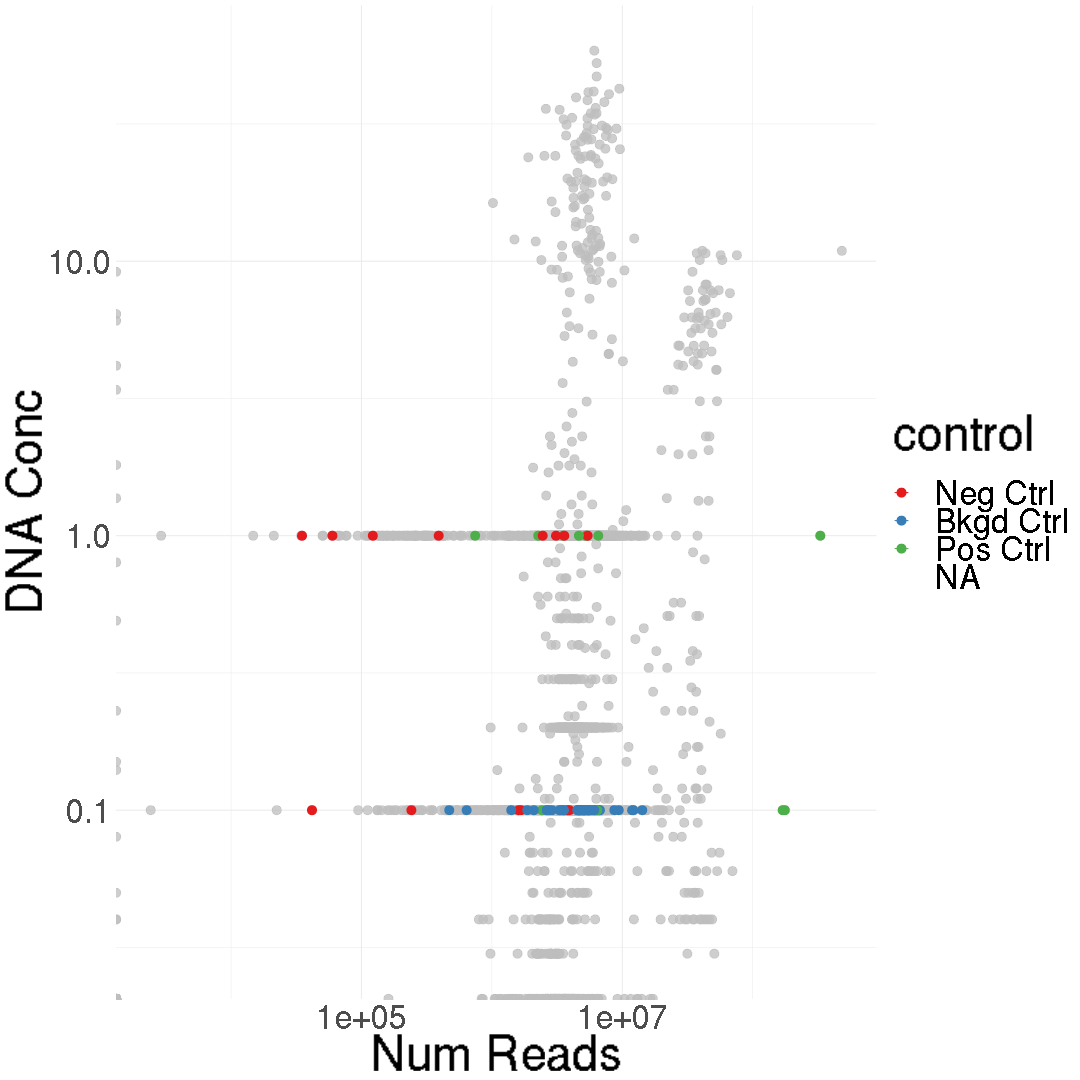

In [88]:
%%R -i qc_mdata -w 1080 -h 1080

qc_mdata$control = ordered(qc_mdata$control, levels=c('Neg Ctrl', 'Bkgd Ctrl', 'Pos Ctrl'))
ggplot(qc_mdata, aes(x=num_reads, y=library_QC_concentration, color=control)) +
    geom_point(size=4, alpha=0.75, color='grey') +
    geom_point(size=4, alpha=1, data=qc_mdata[qc_mdata$control != 'Case',]) +
    stat_ellipse(data=qc_mdata[qc_mdata$control != 'Case',]) +
    theme_minimal() +
    ylab('DNA Conc') +
    xlab('Num Reads') +
    scale_x_log10() +
    scale_y_log10() +
    scale_color_brewer(palette='Set1') +
    theme(
        text = element_text(size=50),
        legend.position='right',
    )

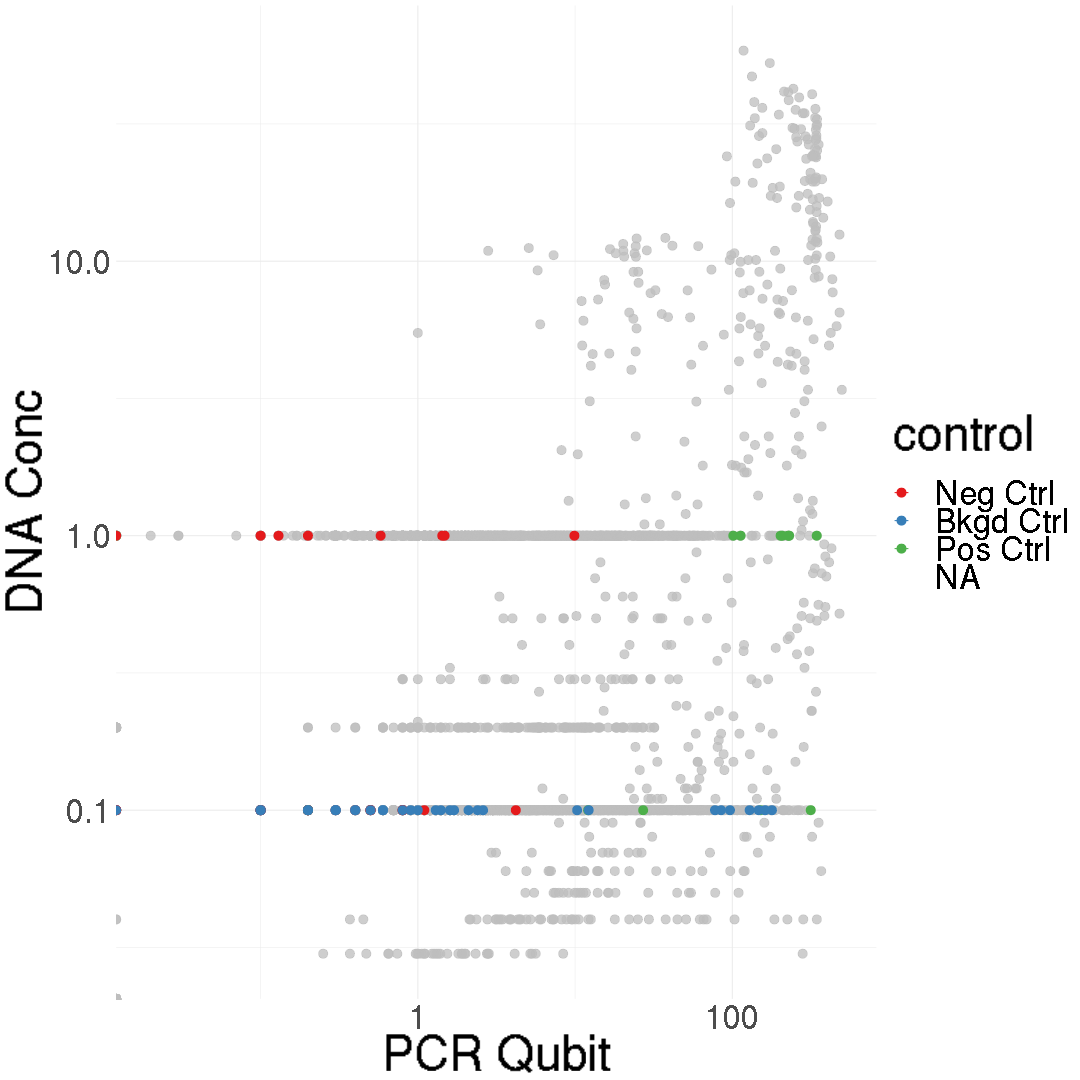

In [90]:
%%R -i qc_mdata -w 1080 -h 1080

qc_mdata$control = ordered(qc_mdata$control, levels=c('Neg Ctrl', 'Bkgd Ctrl', 'Pos Ctrl'))
ggplot(qc_mdata, aes(x=library_post_PCR_Qubit, y=library_QC_concentration, color=control)) +
    geom_point(size=4, alpha=0.75, color='grey') +
    geom_point(size=4, alpha=1, data=qc_mdata[qc_mdata$control != 'Case',]) +
    stat_ellipse(data=qc_mdata[qc_mdata$control != 'Case',]) +
    theme_minimal() +
    ylab('DNA Conc') +
    xlab('PCR Qubit') +
    scale_x_log10() +
    scale_y_log10() +
    scale_color_brewer(palette='Set1') +
    theme(
        text = element_text(size=50),
        legend.position='right',
    )

In [26]:
qc_mdata = mdata[['city', 'continent', 'surface_ontology_fine', 'num_reads', 'library_post_PCR_Qubit', 'library_QC_concentration',]]
qc_mdata = qc_mdata.dropna(how='all')
qc_mdata['library_post_PCR_Qubit'] = [asfloat(el) for el in qc_mdata['library_post_PCR_Qubit']]
qc_mdata['library_QC_concentration'] = [asfloat(el) for el in qc_mdata['library_QC_concentration']]
qc_mdata['city'] = [str(el) for el in qc_mdata['city']]
qc_mdata['continent'] = [str(el) for el in qc_mdata['continent']]
qc_mdata['surface_ontology_fine'] = [str(el) for el in qc_mdata['surface_ontology_fine']]


city_qc = qc_mdata.groupby('city').mean()
surface_qc = qc_mdata.groupby('surface_ontology_fine').mean()
city_qc['city'] = city_qc.index
surface_qc['surface'] = surface_qc.index
city_qc.head()

,num_reads,library_post_PCR_Qubit,library_QC_concentration,city
city,,,,
auckland,4.555692e+06,349.676923,9.707692,auckland
baltimore,2.960858e+06,3.121429,0.100000,baltimore
barcelona,NaN,NaN,NaN,barcelona
belfast,4.827062e+06,2.220000,0.100000,belfast
berlin,1.339581e+07,11.779636,1.286727,berlin


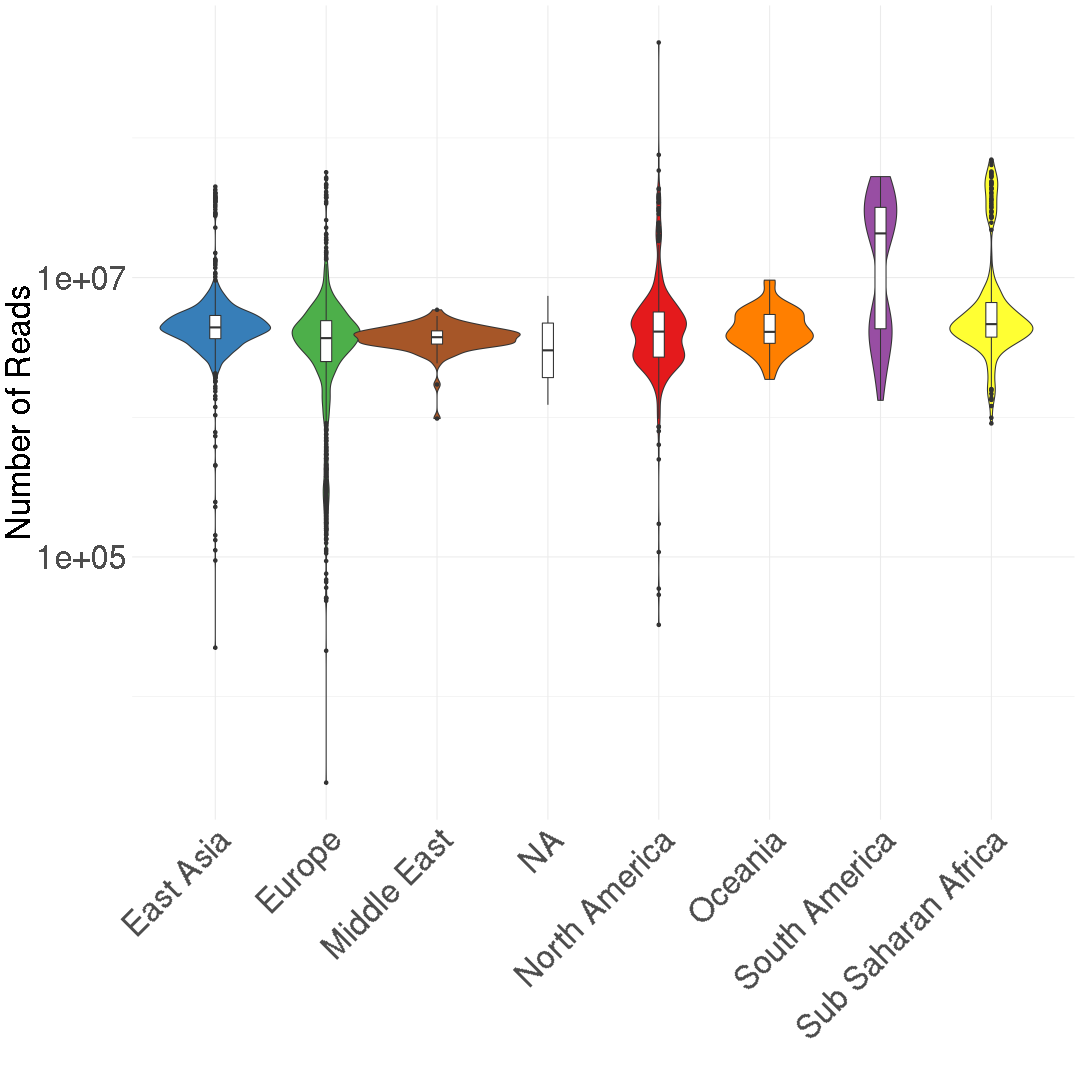

In [32]:
%%R -i qc_mdata -w 1080 -h 1080

continents =  c(
        'north_america',
        'east_asia',
        'europe',
        'south_america',
        'oceania',
        'sub_saharan_africa',
        'middle_east'
)
qc_mdata$continent = ordered(
    qc_mdata$continent,
    levels=continents
)
qc_mdata$continent2 = toTitleCase(unlist(lapply(strsplit(as.character(qc_mdata$continent), "_"), FUN=function(x){paste0(x, collapse=" ")})))



ggplot(qc_mdata, aes(x=continent2, y=num_reads, fill=continent)) +
    geom_violin(width=1.5) +
    geom_boxplot(fill='white', width=0.1) +
    theme_minimal() +
    scale_y_log10() +
    scale_fill_brewer(palette='Set1') +
    ylab('Number of Reads') +
    xlab('') +
    theme(
        text = element_text(size=40),
        legend.position='none',
        axis.text.x = element_text(angle = 45, hjust = 1),
    )

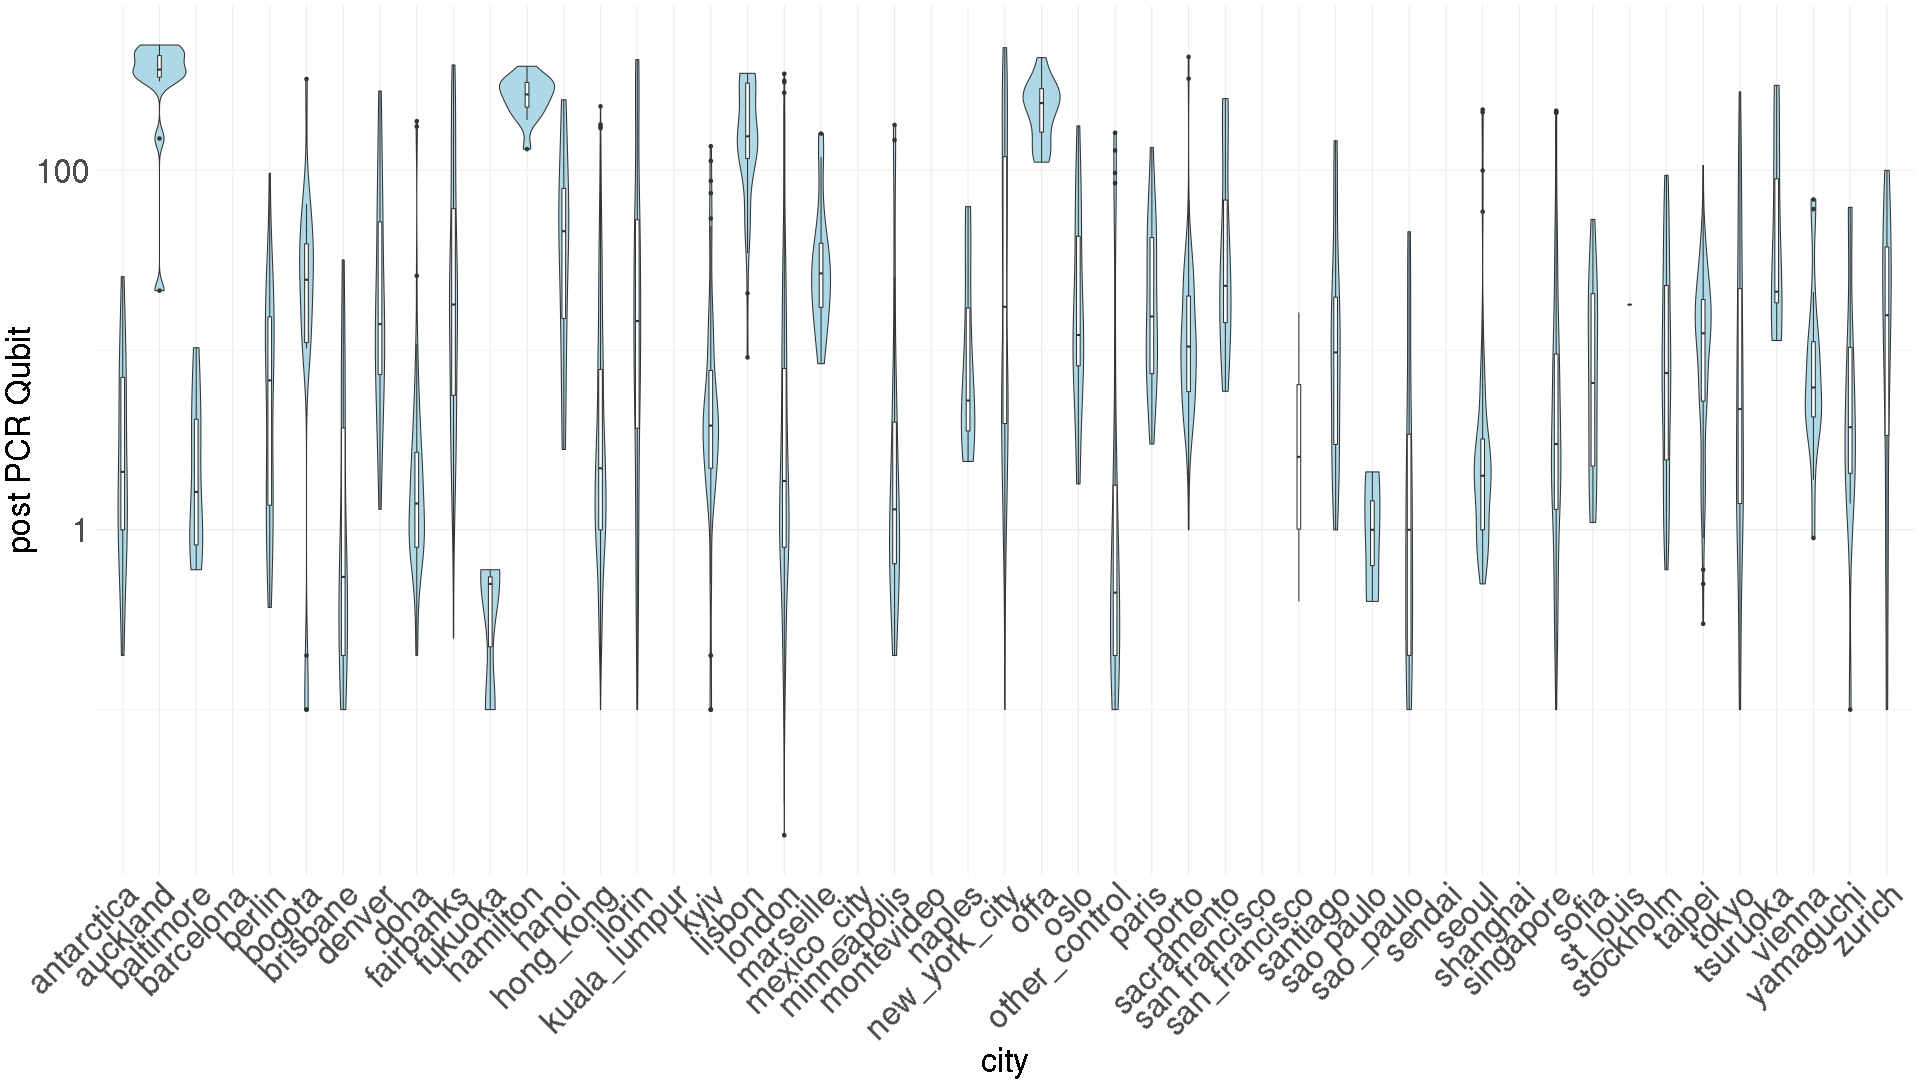

In [9]:
%%R -i qc_mdata -w 1920 -h 1080


ggplot(qc_mdata, aes(x=city, y=library_post_PCR_Qubit)) +
    geom_violin(fill='lightblue', width=1.5) +
    geom_boxplot(fill='white', width=0.1) +
    theme_minimal() +
    scale_y_log10() +
    scale_fill_brewer(palette='Set1') +
    ylab('post PCR Qubit') +
    theme(
        text = element_text(size=40),
        legend.position='none',
        axis.text.x = element_text(angle = 45, hjust = 1),
    )

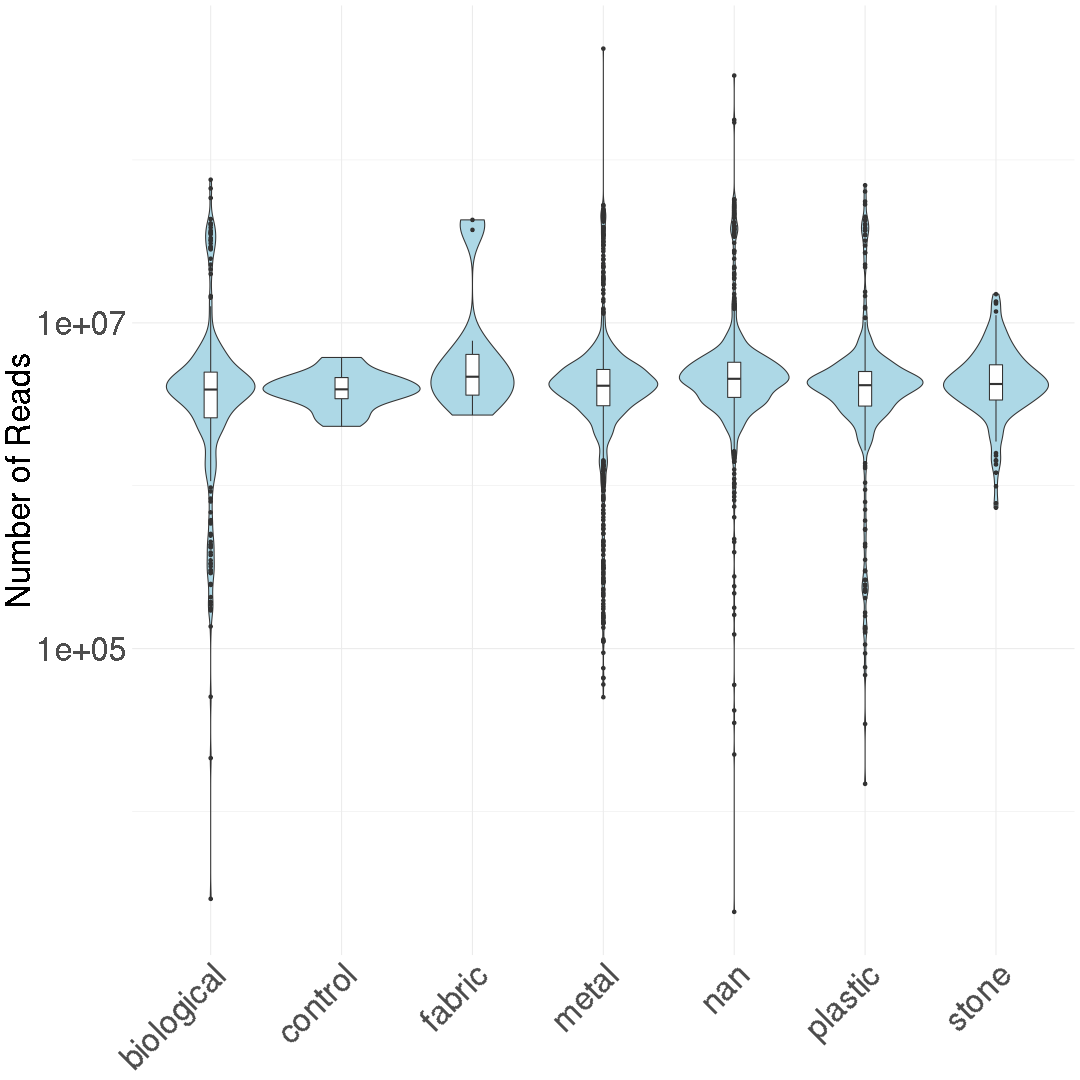

In [10]:
%%R -i qc_mdata -w 1080 -h 1080


ggplot(qc_mdata, aes(x=surface_ontology_fine, y=num_reads)) +
    geom_violin(fill='lightblue', width=1.2) +
    geom_boxplot(fill='white', width=0.1) +
    theme_minimal() +
    scale_y_log10() +
    scale_fill_brewer(palette='Set1') +
    ylab('Number of Reads') +
    theme(
        text = element_text(size=40),
        legend.position='none',
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x=element_blank(),
        
    )

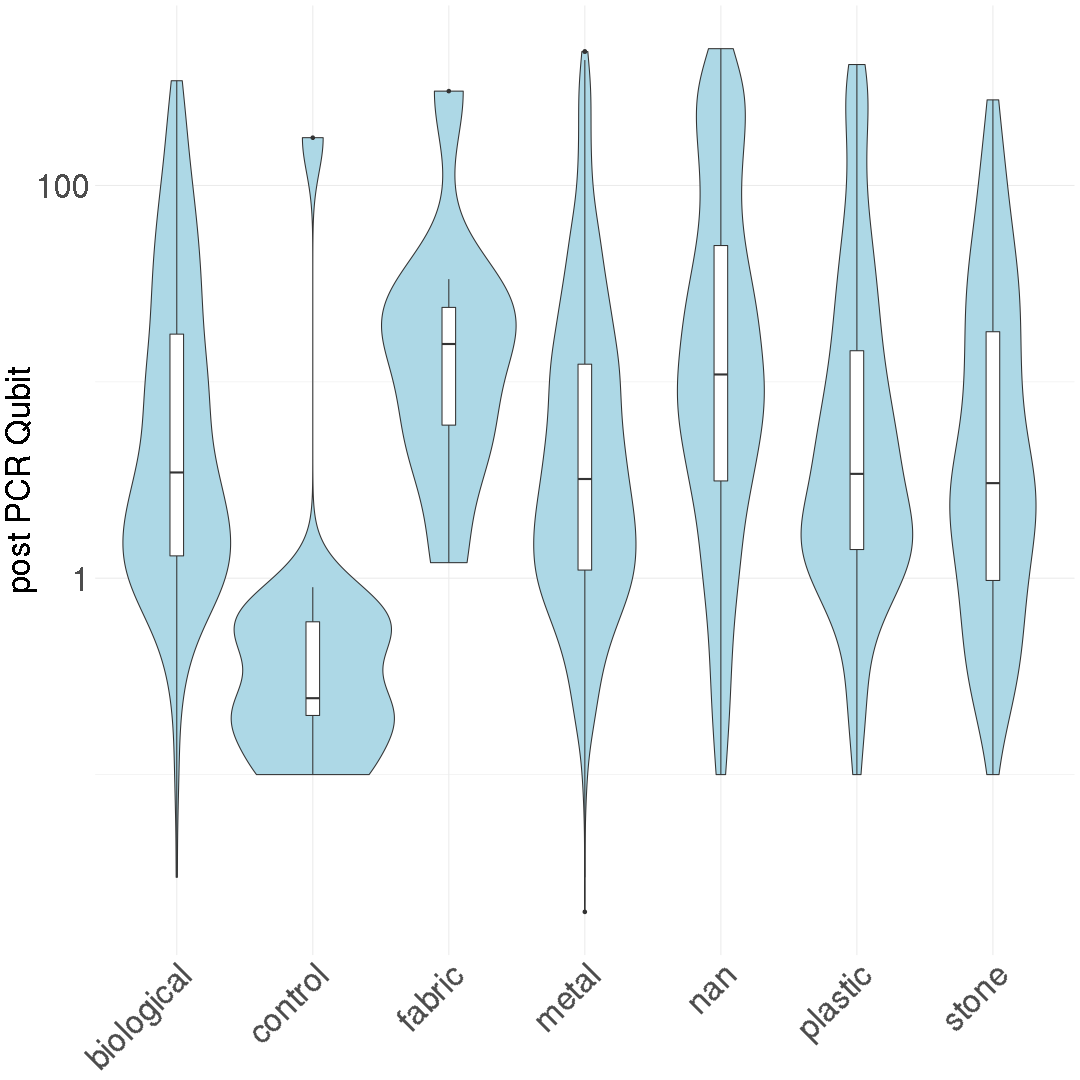

In [11]:
%%R -i qc_mdata -w 1080 -h 1080


ggplot(qc_mdata, aes(x=surface_ontology_fine, y=library_post_PCR_Qubit)) +
    geom_violin(fill='lightblue', width=1.2) +
    geom_boxplot(fill='white', width=0.1) +
    theme_minimal() +
    scale_y_log10() +
    scale_fill_brewer(palette='Set1') +
    ylab('post PCR Qubit') +
    theme(
        text = element_text(size=40),
        legend.position='none',
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x=element_blank(),
        
    )

In [14]:
kmer_stats = core_tabler.csv_in_dir('other/kmer_complexity_stats.csv')

'''
def iscontrol(el):
    if el == 0:
        return 'Case'
    if el in ['ctrl cities', 'positive_control', 'poszymo']:
        return 'Pos/Bkgd Control'
    if el in ['negative_control', 'dry tube', 'dry tube & swab', 'tube & rna/dna out', 'tube & rna/dna out & swab']:
        return 'Neg Control'
    return 'Other'
'''   

kmer_stats['control'] = core_tabler.metadata['control_type'].apply(iscontrol)
kmer_stats.head()

,n_kmers,n_singletons,max_count,total_kmers,entropy,mean,control
haib18CEM5453_HMC2KCCXY_SL336601,1029253.0,944870.0,2170.0,1209819.0,19.399514,1.175434,Case
haib18CEM5453_HMCMJCCXY_SL336347,965208.0,898618.0,4102.0,1209228.0,18.611318,1.252816,Case
haib18CEM5453_HMGW3CCXY_SL342604,846501.0,799042.0,6139.0,1209544.0,17.230715,1.428875,Case
haib17CEM5106_HCCGHCCXY_SL270242,1082352.0,1002465.0,951.0,1209948.0,19.769319,1.117888,Case
haib18CEM5453_HNHKFCCXY_SL346173,1039790.0,969555.0,2401.0,1209509.0,19.333180,1.163224,Case


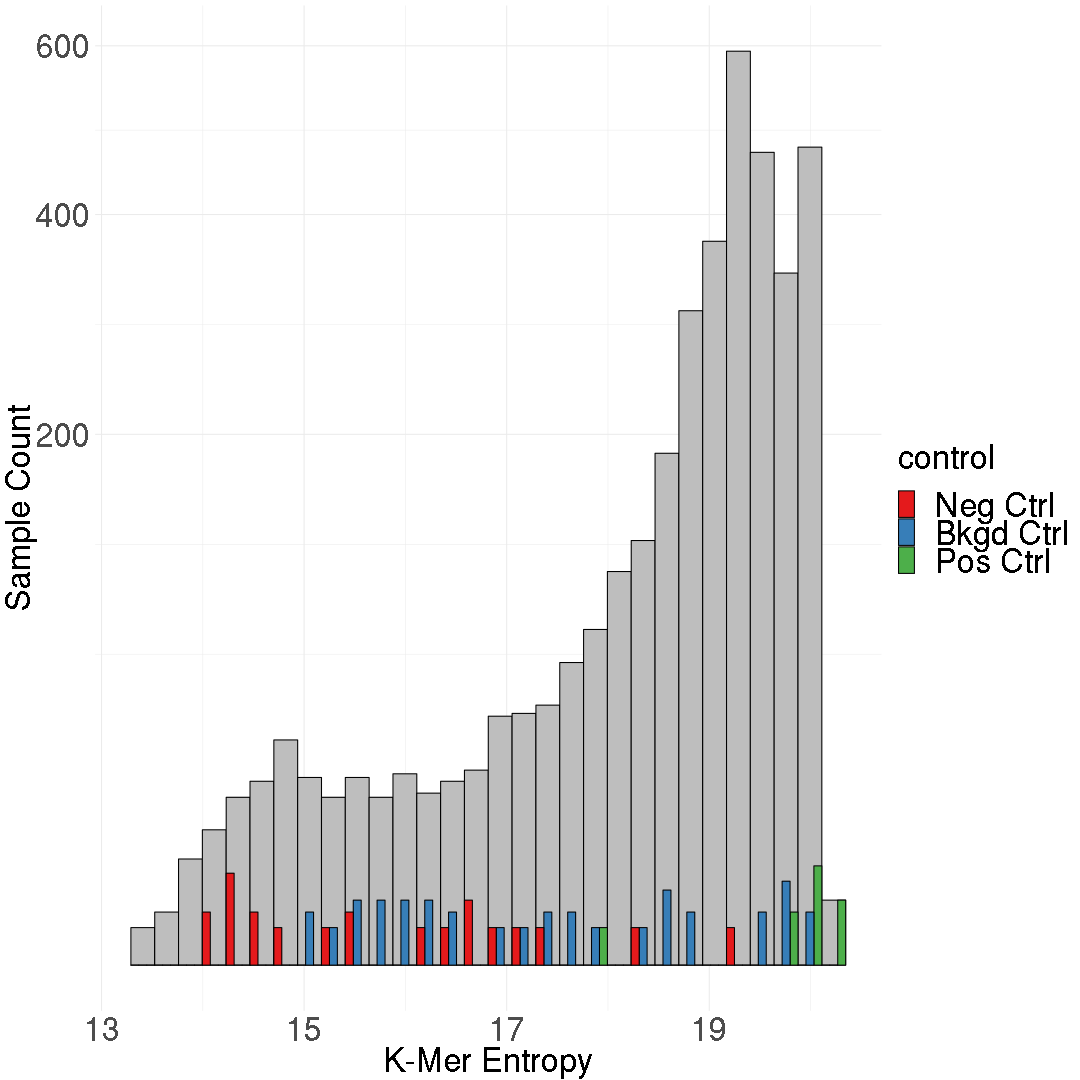

In [16]:
%%R -i kmer_stats -w 1080 -h 1080

kmer_stats$control = ordered(kmer_stats$control, levels=c('Neg Ctrl', 'Bkgd Ctrl', 'Pos Ctrl'))
ggplot(kmer_stats, aes(x=entropy, fill=control)) +
    geom_histogram(position='dodge', color='black', fill='grey') +
    geom_histogram(position='dodge', color='black',  data=kmer_stats[kmer_stats$control != 'Case',]) +
    theme_minimal() +
    scale_fill_brewer(palette='Set1') +
    ylab('Sample Count') +
    xlab('K-Mer Entropy') +
    scale_y_sqrt() +
    theme(
        text = element_text(size=40),
        legend.position='right',
        
    )

In [47]:
fails = kmer_stats.query('entropy < 14')
fails = fails.query('control == "Case"')
print(fails.shape)


(12, 7)


In [37]:

fc_continent = pd.crosstab(core_tabler.metadata['continent'], core_tabler.metadata['hudson_alpha_flowcell'])
fc_city = pd.crosstab(core_tabler.metadata['city'], core_tabler.metadata['hudson_alpha_flowcell'])
fc_continent

hudson_alpha_flowcell,0,H2NYMCCXY,H3KHWCCXY,H3MGVCCXY,H75CGCCXY,H7HJMCCXY,H7KYMCCXY,HCCGHCCXY,HCY5HCCXY,HKC32ALXX,HMC2KCCXY,HMCMJCCXY,HMGMHCCXY,HMGN5CCXY,HMGTJCCXY,HMGW3CCXY,HNGH3CCXY,HNHKFCCXY,HT5YVCCXY
continent,,,,,,,,,,,,,,,,,,,
0,0,0,0,35,0,0,0,0,0,0,0,5,0,0,0,32,0,0,1
east_asia,34,0,0,11,0,0,0,0,0,26,280,78,84,0,48,81,0,463,262
europe,164,0,96,0,16,26,38,384,192,17,8,118,106,0,27,91,0,1,0
latin_america,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
middle_east,0,0,0,0,0,0,0,0,0,0,0,66,0,0,0,16,0,0,0
north_america,18,36,0,100,32,0,58,0,0,0,0,110,0,0,21,48,0,0,0
oceania,0,0,0,0,32,0,0,0,0,0,0,2,0,0,0,14,0,0,0
south_america,20,0,0,3,16,0,0,0,0,29,0,4,0,0,0,0,0,0,25
sub_saharan_africa,0,26,0,0,0,66,0,0,0,24,0,0,0,96,0,0,96,0,0


In [38]:
pd.concat([fc_continent, fc_city]).to_csv('/home/dcdanko/Dropbox/resources_and_shared/MetaSUB/Playground_David/sites_vs_flowcells.csv')

In [39]:
print((fc_city > 0).sum().median())
print((fc_continent > 0).sum().median())

3.0
2.0


In [43]:
counts = pd.concat([(fc_city > 0).sum(), (fc_continent > 0).sum()], axis=1)
counts.columns = ['city', 'city']
counts.loc['H2NYMCCXY', 'city'].iloc[0]

3

In [41]:
core_tabler = MetaSUBTableFactory.core_factory()

taxa = core_tabler.taxonomy(normalize=True).fillna(0)

taxa_umap = umap(taxa > 0, n_neighbors=100)
taxa_umap['continent'] = [str(el) for el in core_tabler.metadata['continent'].loc[taxa.index]]
taxa_umap['city'] = [str(el) for el in core_tabler.metadata['city'].loc[taxa.index]]
taxa_umap['climate'] = [str(el) for el in core_tabler.metadata['city_koppen_climate'].loc[taxa.index]]
print(taxa.shape)
taxa_umap['hudson_alpha_flowcell'] = [str(el) for el in core_tabler.metadata['hudson_alpha_flowcell'].loc[taxa.index]]
taxa_umap['project'] = [str(el) for el in core_tabler.metadata['project'].loc[taxa.index]]

(3639, 4424)


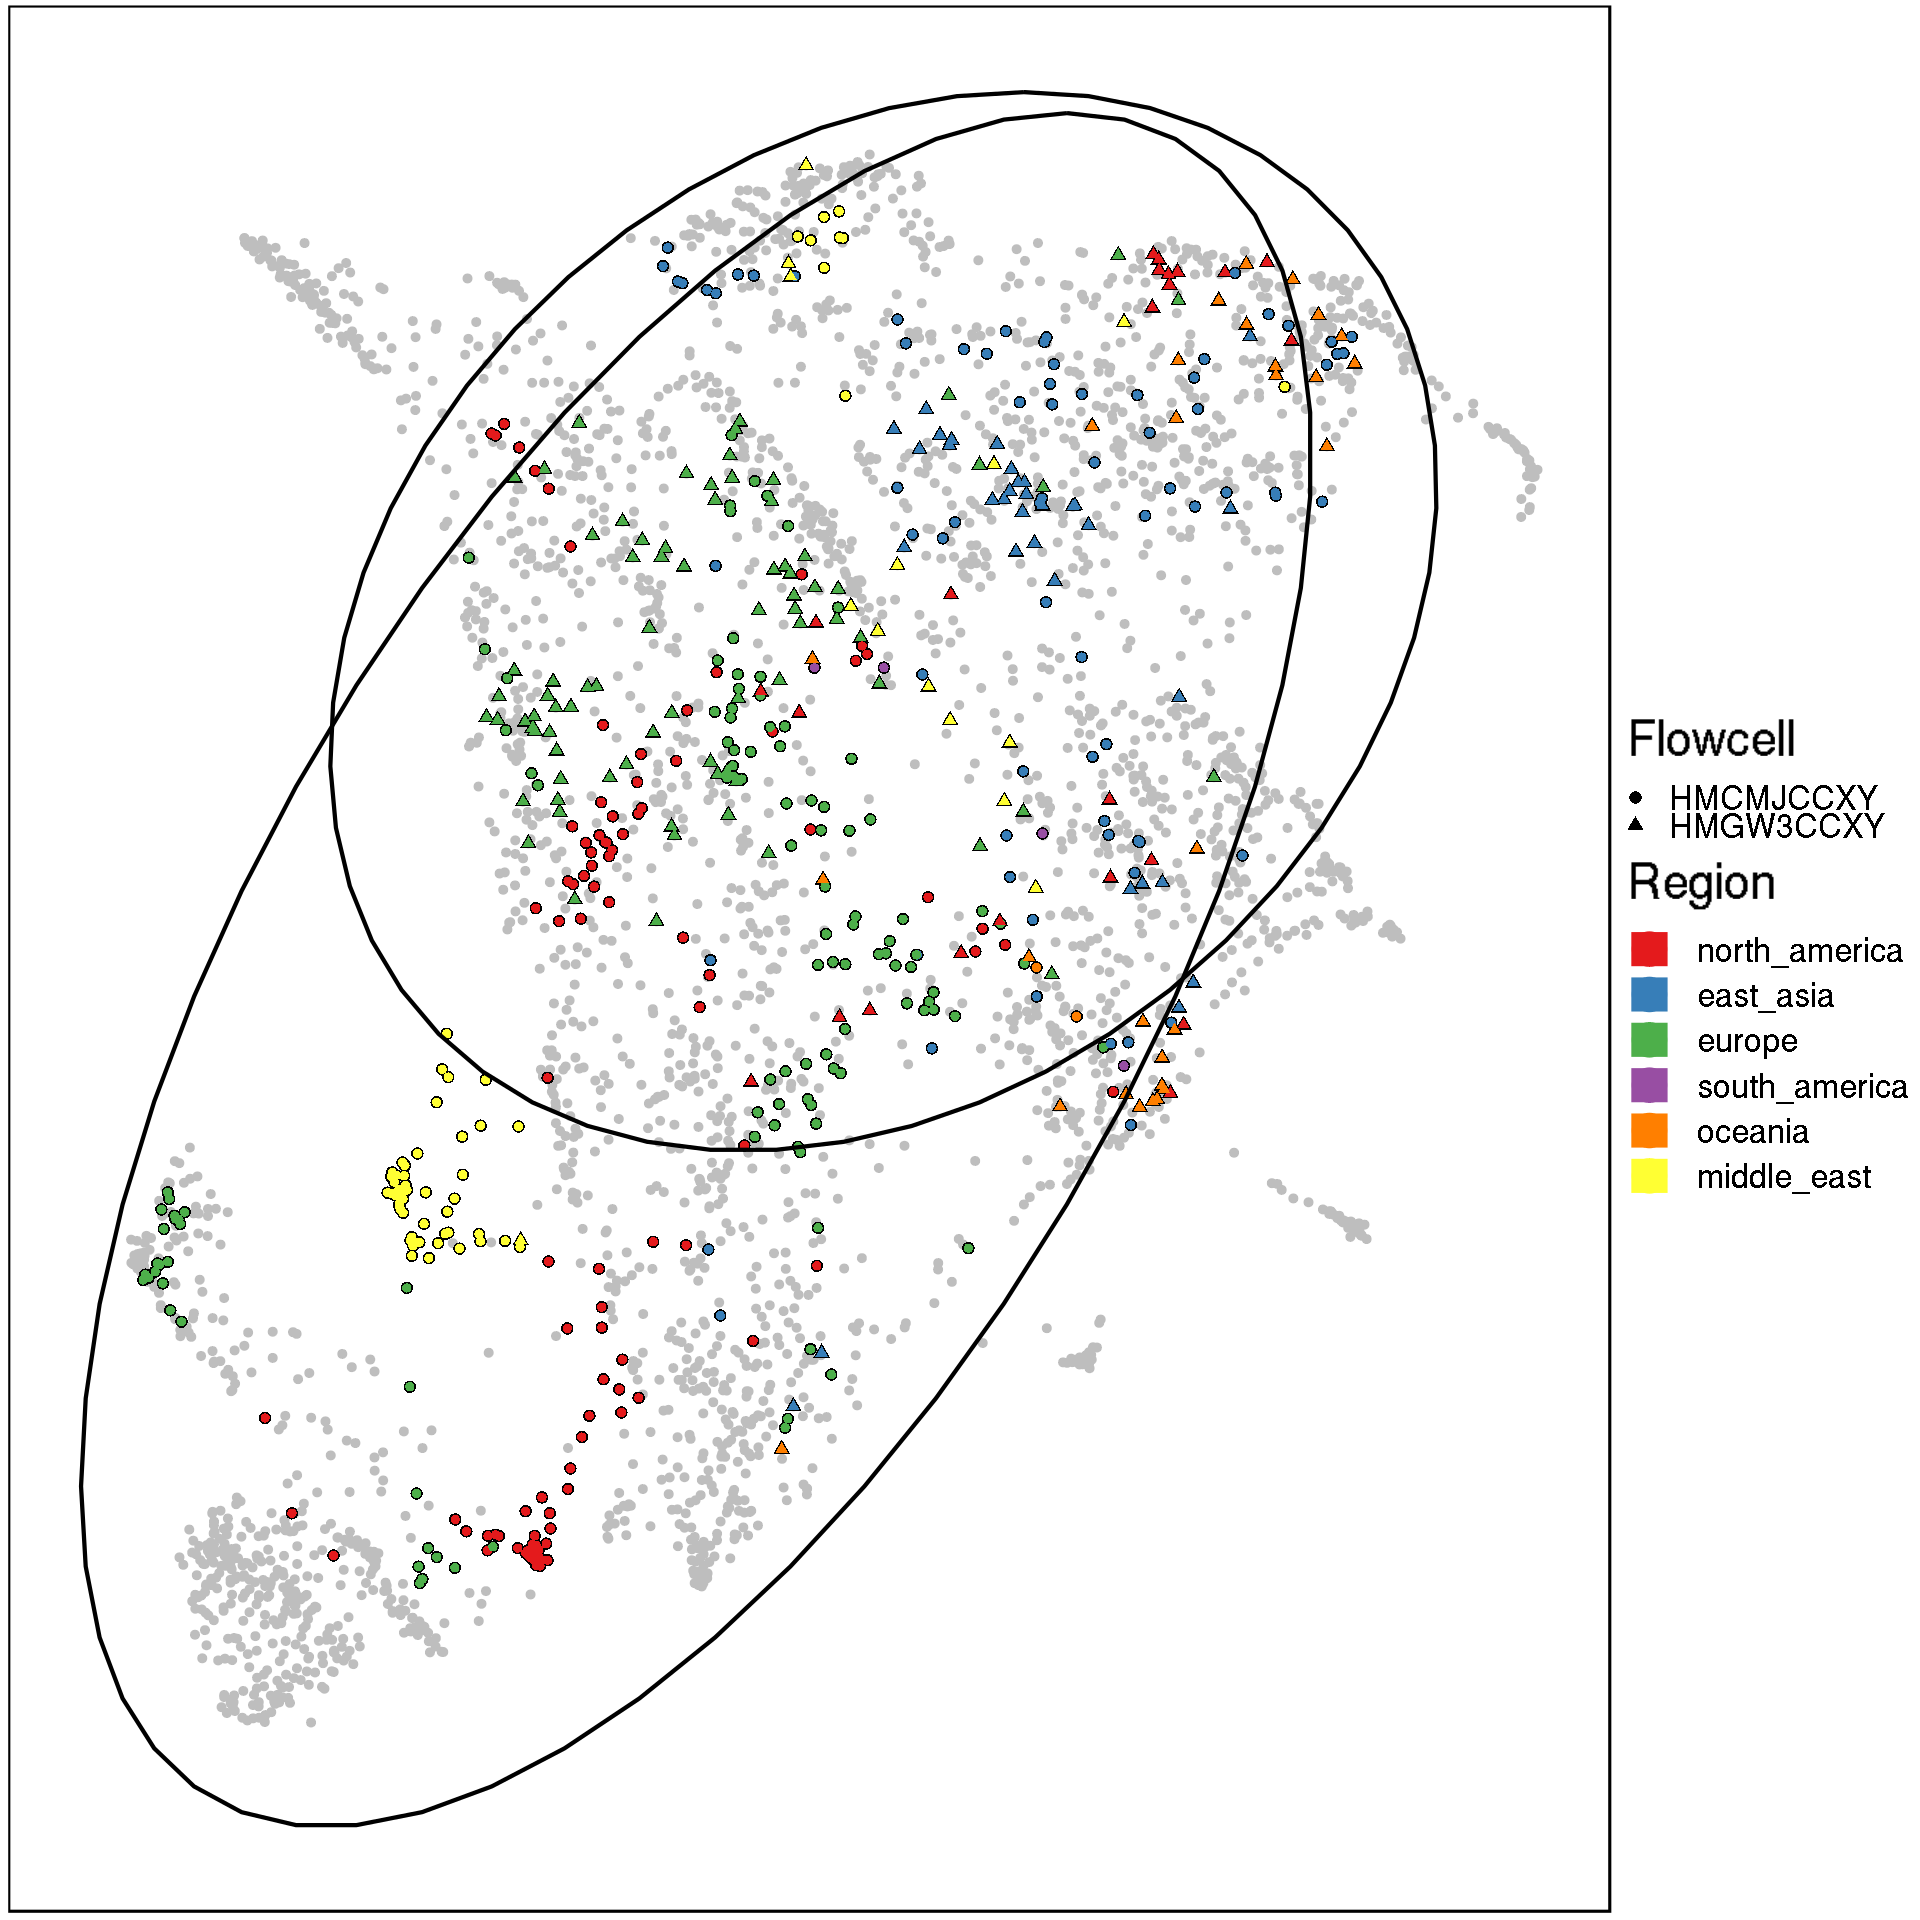

In [19]:
%%R -i taxa_umap -w 1920 -h 1920

taxa_umap$continent = ordered(
    taxa_umap$continent,
    levels=c(
        '0',
        'north_america',
        'east_asia',
        'europe',
        'south_america',
        'oceania',
        'sub_saharan_africa',
        'middle_east'
))
mytbl = taxa_umap[taxa_umap$continent != '0',]
mytbl2 = mytbl[mytbl$hudson_alpha_flowcell %in% c('HMCMJCCXY', 'HMGW3CCXY'),]
ggplot(mytbl2, aes(x=C0, y=C1, color=continent, shape=hudson_alpha_flowcell)) +
    geom_point(size=4, colour = "grey", data=mytbl, shape=19) +
    geom_point(size=5.5, colour = "black") +
    geom_point(size=4) +
    stat_ellipse(size=2, level=0.95, aes(group=hudson_alpha_flowcell)) +
    theme_minimal() +
    scale_color_brewer(palette = "Set1", direction=1) +
    guides(color = guide_legend(override.aes=list(size=16))) +
    theme_minimal() +
    coord_flip() +
    labs(color='Region', shape='Flowcell') +
    theme(
        text = element_text(size=50),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position='right',
        axis.text.x=element_blank(),
        axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        axis.title.y=element_blank(),
        panel.border = element_rect(colour="black", fill=NA, size=2),
    )

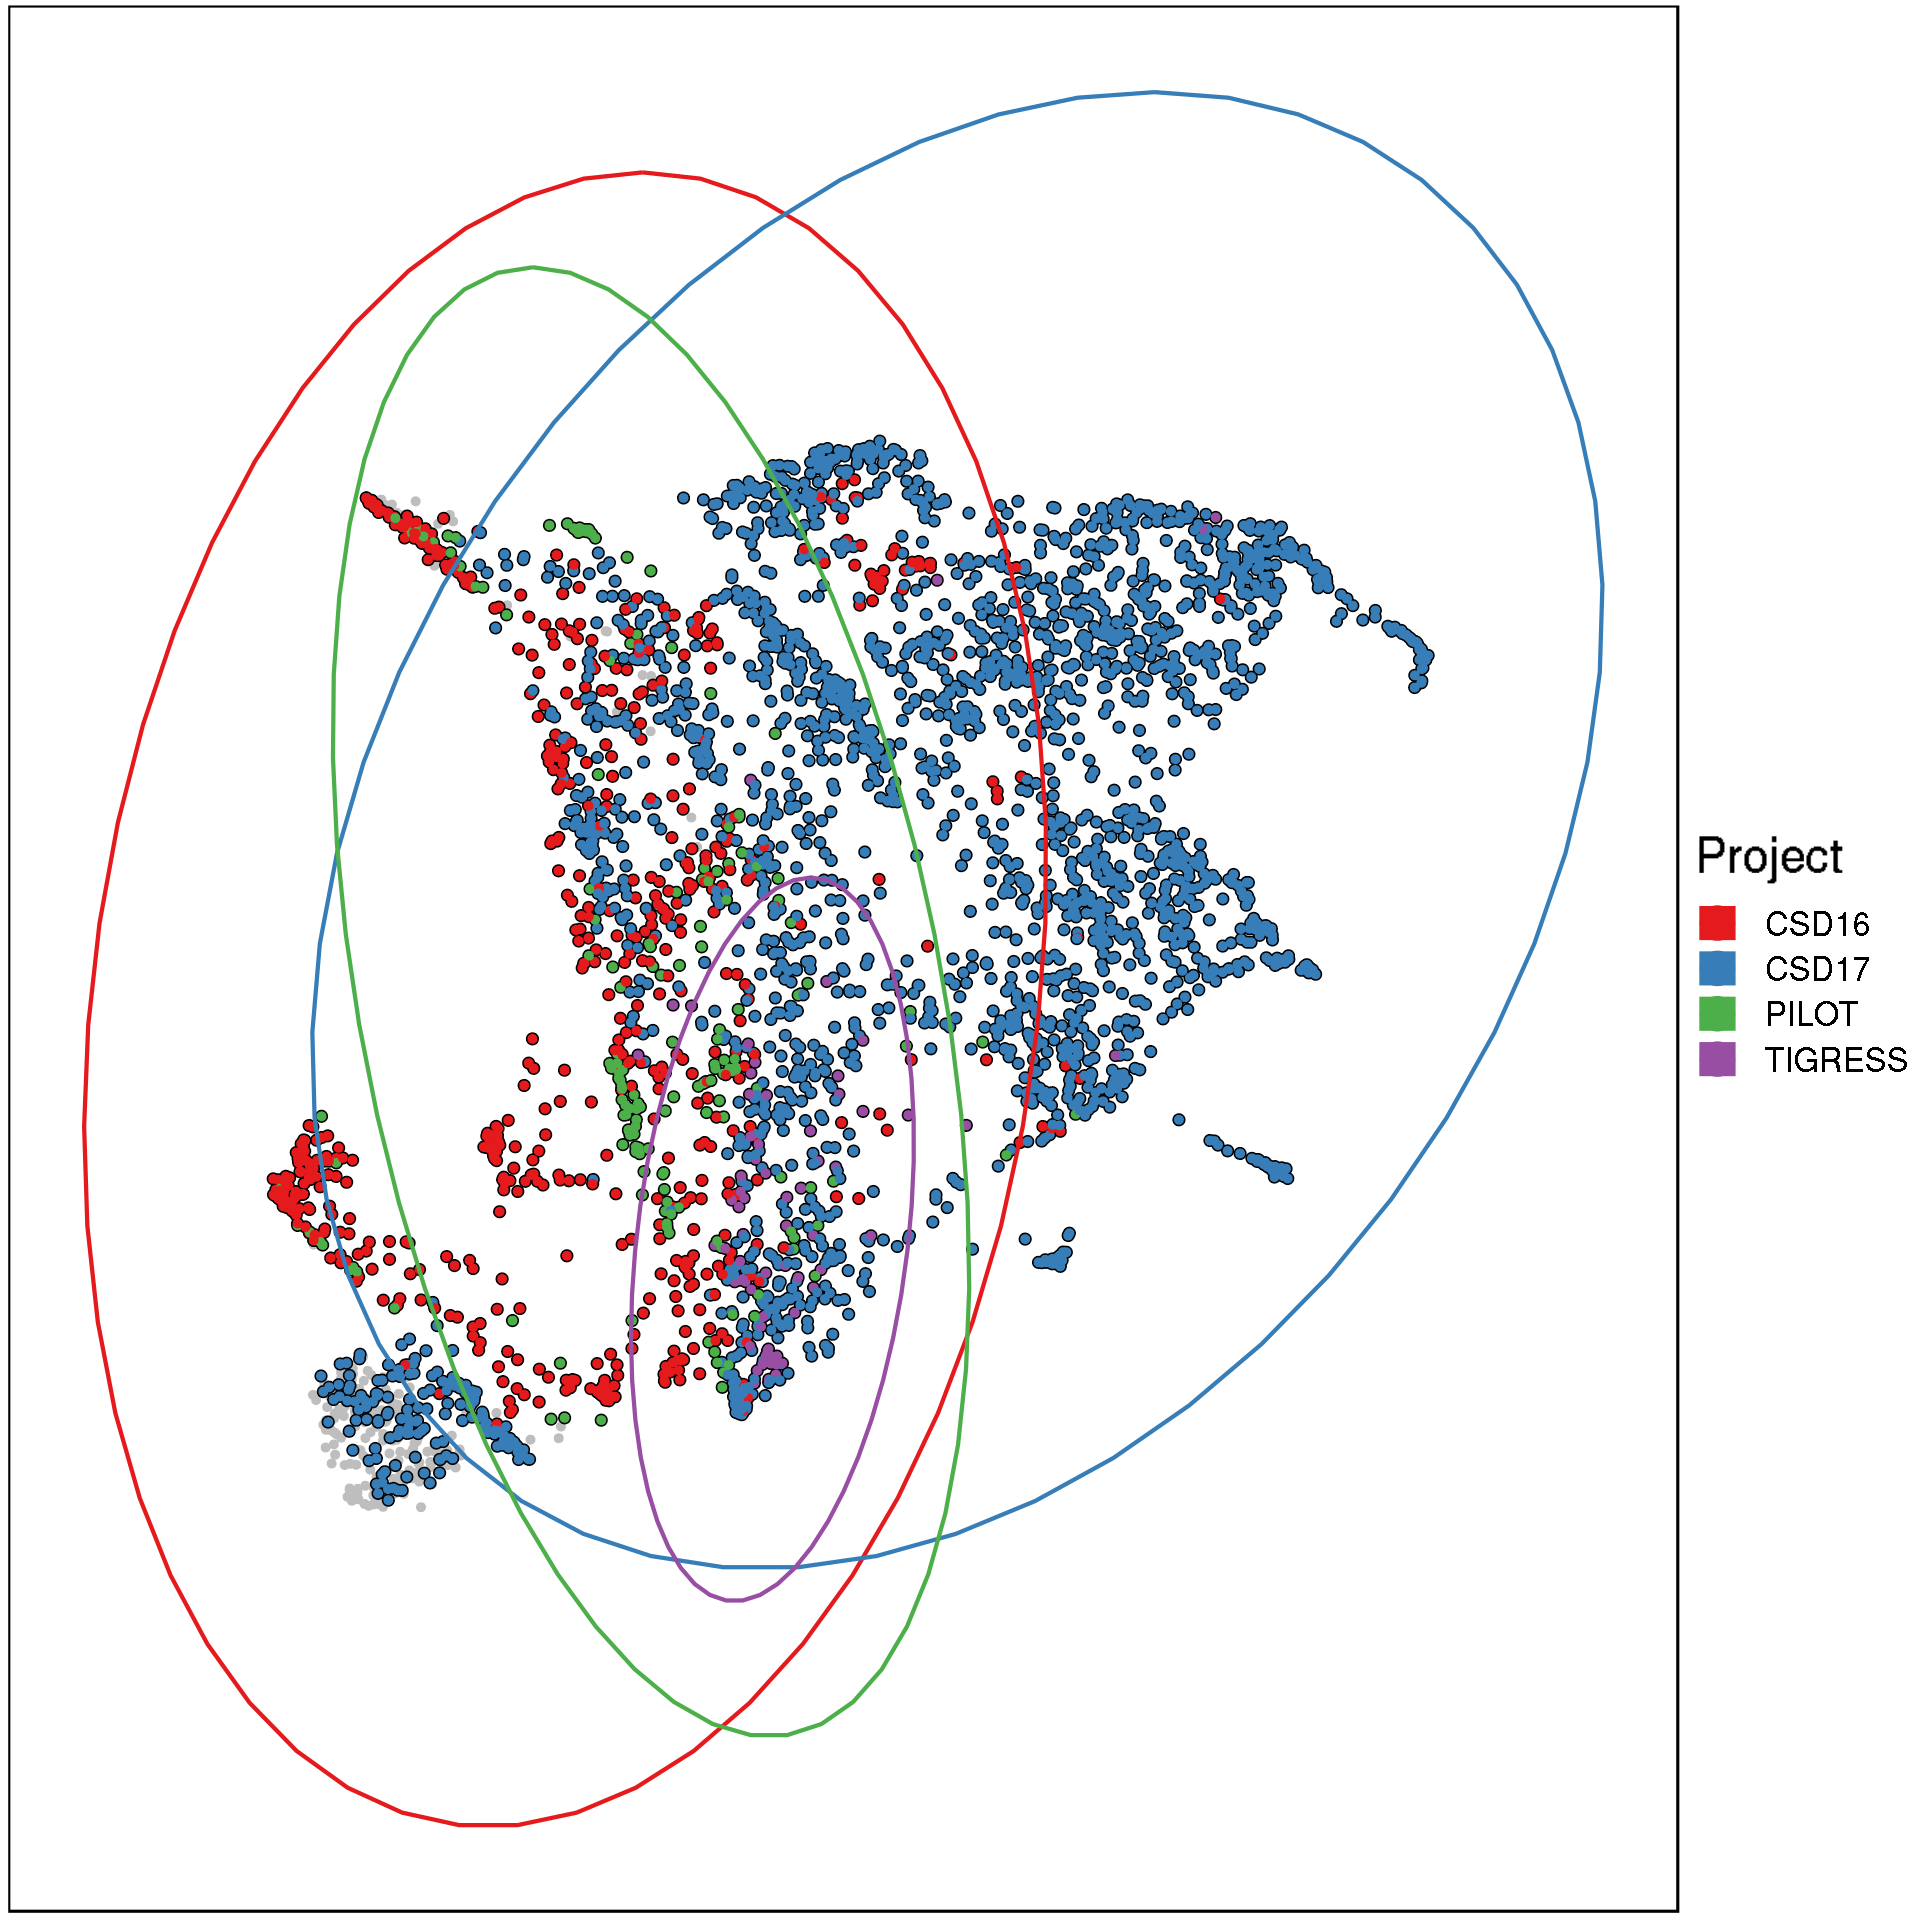

In [52]:
%%R -i taxa_umap -w 1920 -h 1920

mytbl = taxa_umap
mytbl = mytbl[mytbl$project %in% c('CSD16', 'CSD17', 'PILOT', 'TIGRESS'),]
ggplot(mytbl, aes(x=C0, y=C1, color=project)) +
    geom_point(size=4, colour = "grey", data=taxa_umap, shape=19) +
    geom_point(size=5.5, colour = "black") +
    geom_point(size=4) +
    stat_ellipse(size=2, level=0.99, aes(group=project)) +
    theme_minimal() +
    scale_color_brewer(palette = "Set1", direction=1) +
    guides(color = guide_legend(override.aes=list(size=16))) +
    theme_minimal() +
    coord_flip() +
    labs(color='Project', shape='Flowcell') +
    theme(
        text = element_text(size=50),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position='right',
        axis.text.x=element_blank(),
        axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        axis.title.y=element_blank(),
        panel.border = element_rect(colour="black", fill=NA, size=2),
    )

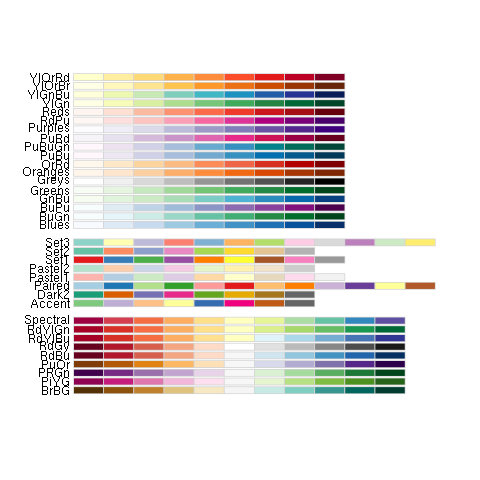

In [81]:
%%R 

display.brewer.all()